### Time series forecasting with a basic LSTM, stacked LSTM, and bidirectional LSTM models. 

In this project, we applied Long Short-Term Memory (LSTM) neural networks to perform time series forecasting on the Air Passengers dataset. The goal of this work was to build a predictive model that can forecast the number of air passengers based on historical data.



In [53]:
import pandas as pd 
import numpy as np         
import matplotlib.pyplot as plt  

from datetime import datetime 

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense, Dropout
from numpy import array
from sklearn.metrics import mean_squared_error
from math import sqrt

%matplotlib inline 

import warnings                  
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [54]:
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)

In [55]:
dataset = pd.read_csv('Data/airline-passengers.csv', engine='python')

In [56]:
dataset.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


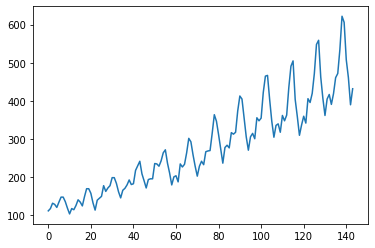

In [57]:
plt.plot(dataset['Passengers']);

In [58]:
#We transformed the 'Month' column into a datetime format and extracted the month component.
#We will use the passenger count and month information as an input to the model.
dataset['Month'] = pd.to_datetime(dataset['Month'])
dataset['Month'] = dataset['Month'].dt.month
dataset_values = dataset[['Passengers', 'Month']].values.astype('float32') #convert the integer values to floating point values, which are more suitable for modeling with a neural network.

### Split into train and test sets
In time series we must follow the order when splitting into train and test sets. This dataset was split into training and testing sets, with 67% of the data used for training.

In [59]:
train_size = int(len(dataset_values) * 0.67)
test_size = len(dataset_values) - train_size
train, test = dataset_values[0:train_size], dataset_values[train_size:len(dataset_values)]
print(len(train), len(test))

96 48


### Scaling data
We will use the passenger count and month information as an input to the model. <br>
It's generally a good practice to **Scale** your data before using it as input to a neural network, especially when dealing with features that have different scales or magnitudes. we are using 'MinMaxScaler' to scales both "Passengers" and "Month" to the [0, 1] range. 

In [60]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
test_scaled=scaler.transform(test)

In [61]:
# look_back: number of previous time steps to use as input variables to predict the next time period—in this case, defaulted to 1.
# output: X is the number of passengers at a given time (t), and Y is the number of passengers at the next time (t + 1).
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]  #get look_back sequences
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0]) #get the target after look_back sequences
    return np.array(dataX), np.array(dataY)

In [62]:
look_back = 5   #you are creating input sequences of length 5 (i.e., 5 time steps)
trainX, trainY = create_dataset(train_scaled, look_back)
testX, testY = create_dataset(test_scaled, look_back)

### Build Models

#### The input to an LSTM network typically consists of a 3D tensor with the shape (batch_size, timesteps, input_features).

Samples: number of individual data points in your dataset <br>
Time steps : the number of data points in each sequence. It determines how far back in time the model looks when making predictions. <br>
Features : the number of features 

In [63]:
print("trainX Shape: ",trainX.shape) #[samples, time steps, features]
print("trainY Shape: ",trainY.shape)

print("testX Shape: ",testX.shape) #[samples, time steps, features]
print("testY Shape: ",testY.shape)


trainX Shape:  (90, 5, 2)
trainY Shape:  (90,)
testX Shape:  (42, 5, 2)
testY Shape:  (42,)


In [64]:
# # Reshape input to be [samples, time steps, features]
# trainX = np.reshape(trainX, (trainX.shape[0], look_back, trainX.shape[1]))
# testX = np.reshape(testX, (testX.shape[0], look_back, testX.shape[1]))

#### Basic LSTM model

In [2]:
def create_basic_lstm_model(units=50):
    model = Sequential()
    model.add(LSTM(units, input_shape=(look_back, trainX.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    return model

basic_model = create_basic_lstm_model(units=50)
# fit model
basic_model.fit(trainX, trainY, epochs=200, verbose=0)

#### Stacked LSTM Model

In the first LSTM layer 'return_sequences=True' means it will return the full sequence of output,  which is necessary if you want to stack LSTM layers. We designed a Stacked LSTM model with two LSTM layers and a Dense output layer. The choice of activation function was 'relu,' and we used the mean squared error (MSE) as the loss function. 

In [17]:
def create_stacked_lstm_model(units=50, activation='relu'):
    model = Sequential()
    model.add(LSTM(units, activation=activation, return_sequences=True, input_shape=(look_back, trainX.shape[2])))
    model.add(LSTM(units, activation=activation))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

stacked_model = create_stacked_lstm_model(units=50, activation='relu')

# fit model
stacked_model.fit(trainX, trainY, epochs=200, verbose=0)

#### Bidirectional LSTM Model

In [19]:
def create_bidirectional_lstm_model(units=50, activation='relu'):
    model = Sequential()
    model.add(Bidirectional(LSTM(units, activation=activation), input_shape=(look_back, trainX.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

Bi_model = create_bidirectional_lstm_model(units=50, activation='relu')

# fit model
Bi_model.fit(trainX, trainY, epochs=200, verbose=0)

### Test and Evaluate

**Test** the model with the test data. <br>
We had scaled our data so we need to **inverse** the scaling, making them interpretable in terms of the actual number of air passengers. <br>
**Mean Squared Error (MSE)** is a measure of the average squared difference between the predicted values and the actual values. A lower MSE indicates better model performance. <br>
**Root Mean Squared Error (RMSE)** is the square root of the MSE and provides a measure of the average prediction error in the same units as the target variable. A lower RMSE indicates better model performance.

In [67]:
basic_test_predictions = basic_model.predict(testX)
stacked_test_predictions = stacked_model.predict(testX)
bi_test_predictions = Bi_model.predict(testX)

2/2 [==============================] - 0s 2ms/step


In [68]:
# Inverse transform and reshape predictions
def inverse_transform_and_reshape(predictions, scaler, shape):
    predictions_copies = np.repeat(predictions, shape[2], axis=-1)
    return scaler.inverse_transform(np.reshape(predictions_copies, (len(predictions), shape[2])))[:, 0]

basic_pred = inverse_transform_and_reshape(basic_test_predictions, scaler, trainX.shape)
stacked_pred = inverse_transform_and_reshape(stacked_test_predictions, scaler, trainX.shape)
bi_pred = inverse_transform_and_reshape(bi_test_predictions, scaler, trainX.shape)

# Original test label
original_copies_array = np.repeat(testY, trainX.shape[2], axis=-1)
original_testY = scaler.inverse_transform(np.reshape(original_copies_array, (len(testY), trainX.shape[2])))[:, 0]

In [69]:
print("Basic Model:")
mse = mean_squared_error(original_testY, basic_pred)
print("Mean Squared Error (MSE):", mse)
rmse = sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

print("Stacked Model:")
mse = mean_squared_error(original_testY, stacked_pred)
print("Mean Squared Error (MSE):", mse)
rmse = sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

print("Bidirectional Model:")
mse = mean_squared_error(original_testY, bi_pred)
print("Mean Squared Error (MSE):", mse)
rmse = sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

Basic Model:
Mean Squared Error (MSE): 1902.4393
Root Mean Squared Error (RMSE): 43.6169615064448
Stacked Model:
Mean Squared Error (MSE): 719.4529
Root Mean Squared Error (RMSE): 26.82261882925258
Bidirectional Model:
Mean Squared Error (MSE): 1403.3271
Root Mean Squared Error (RMSE): 37.46100837454192


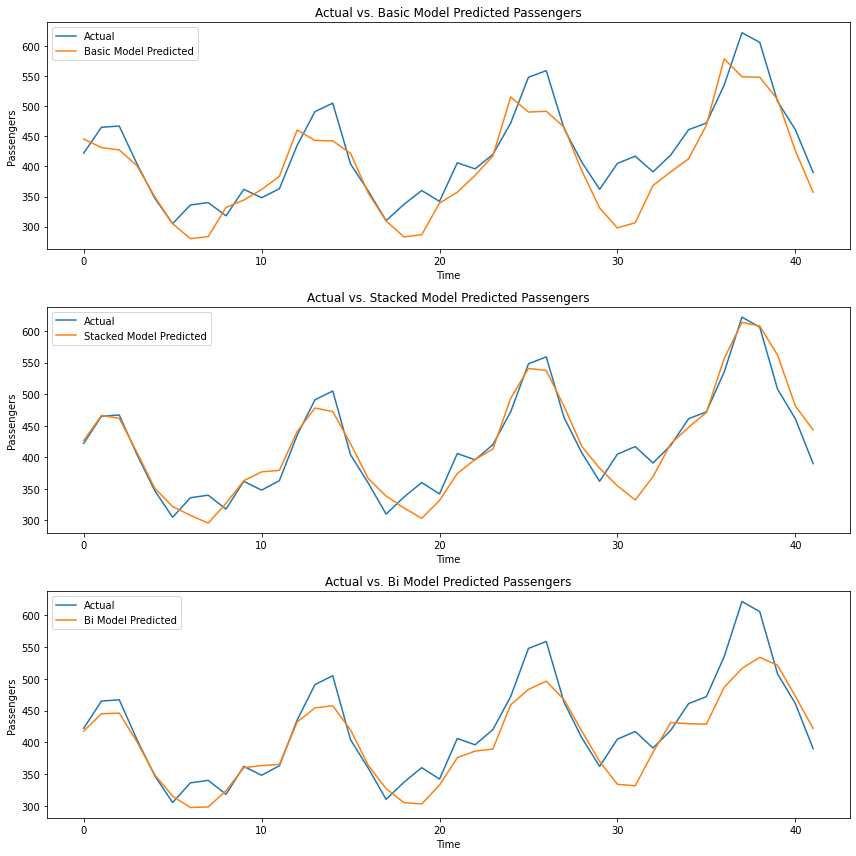

In [71]:
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

# Plot for Basic Model
axes[0].plot(original_testY, label='Actual')
axes[0].plot(basic_pred, label='Basic Model Predicted')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Passengers')
axes[0].legend()
axes[0].set_title('Actual vs. Basic Model Predicted Passengers')

# Plot for Stacked Model
axes[1].plot(original_testY, label='Actual')
axes[1].plot(stacked_pred, label='Stacked Model Predicted')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Passengers')
axes[1].legend()
axes[1].set_title('Actual vs. Stacked Model Predicted Passengers')

# Plot for Bi Model
axes[2].plot(original_testY, label='Actual')
axes[2].plot(bi_pred, label='Bi Model Predicted')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Passengers')
axes[2].legend()
axes[2].set_title('Actual vs. Bi Model Predicted Passengers')

plt.tight_layout() 
plt.show()

### Hyperparameter Tuning with GridSearch

Hyperparameter tuning was applied to optimize the performance of the models for time series forecasting. Hyperparameters are critical settings that control the behavior and architecture of the neural network. The goal was to identify the combination of hyperparameters that produced the best forecasting results. <br>

The **grid_search** function performs an exhaustive search over the parameter grid. This involved training and evaluating multiple instances of the model with different hyperparameter combinations.

The **evaluate_model** function makes predictions with the model on the test data, inverse-transform the predictions to their original scale, and calculate performance metrics.


In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from keras.wrappers.scikit_learn import KerasRegressor


In [120]:
def grid_search(model_type, param_grid):
    regressor = KerasRegressor(build_fn= model_type, verbose=0)
    grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
    grid_search.fit(trainX, trainY)
    return grid_search.best_estimator_.model, grid_search.best_params_

In [137]:
def evaluate_model(model, testX, testY, scaler, trainX_shape):
    predictions = model.predict(testX)
    predictions = inverse_transform_and_reshape(predictions, scaler, trainX_shape) #inverse the scaling
    
    original_copies_array = np.repeat(testY, trainX.shape[2], axis=-1)
    original_testY = scaler.inverse_transform(np.reshape(original_copies_array, (len(testY), trainX.shape[2])))[:, 0]#inverse the scaling of testY

    mse = mean_squared_error(original_testY, predictions)
    rmse = np.sqrt(mse)
    return predictions, original_testY, mse, rmse

In [152]:
# Define parameter grid
param_grid = {'units': [4, 20, 50],
              'batch_size' : [10, 20, 32, 40, 100],
              'epochs' : [10, 50, 100, 200]}

# Train and evaluate basic LSTM
basic_best_model, basic_best_params = grid_search(create_basic_lstm_model, param_grid)
basic_pred, original_testY, basic_mse, basic_rmse = evaluate_model(basic_best_model, testX, testY, scaler, trainX.shape)

# Train and evaluate stacked LSTM
stacked_best_model, stacked_best_params = grid_search(create_stacked_lstm_model, param_grid)
stacked_pred, original_testY, stacked_mse, stacked_rmse = evaluate_model(stacked_best_model, testX, testY, scaler, trainX.shape)

# Train and evaluate Bidirectional LSTM
bi_best_model, bi_best_params = grid_search(create_bidirectional_lstm_model, param_grid)
bi_pred, original_testY, bi_mse, bi_rmse = evaluate_model(bi_best_model, testX, testY, scaler, trainX.shape)

2/2 [==============================] - 0s 3ms/step


In [153]:
print("Basic Model:")
print("Best Hyperparameters:", basic_best_params)
print("Mean Squared Error (MSE):", basic_mse)
print("Root Mean Squared Error (RMSE):", basic_rmse)

print("Stacked Model:")
print("Best Hyperparameters:", stacked_best_params)
print("Mean Squared Error (MSE):", stacked_mse)
print("Root Mean Squared Error (RMSE):", stacked_rmse)

print("Bidirectional Model:")
print("Best Hyperparameters:", bi_best_params)
print("Mean Squared Error (MSE):", bi_mse)
print("Root Mean Squared Error (RMSE):", bi_rmse)

Basic Model:
Best Hyperparameters: {'batch_size': 10, 'epochs': 200, 'units': 20}
Mean Squared Error (MSE): 1943.4325
Root Mean Squared Error (RMSE): 44.08438
Stacked Model:
Best Hyperparameters: {'batch_size': 10, 'epochs': 200, 'units': 50}
Mean Squared Error (MSE): 532.24677
Root Mean Squared Error (RMSE): 23.070475
Bidirectional Model:
Best Hyperparameters: {'batch_size': 10, 'epochs': 200, 'units': 50}
Mean Squared Error (MSE): 821.13885
Root Mean Squared Error (RMSE): 28.655521


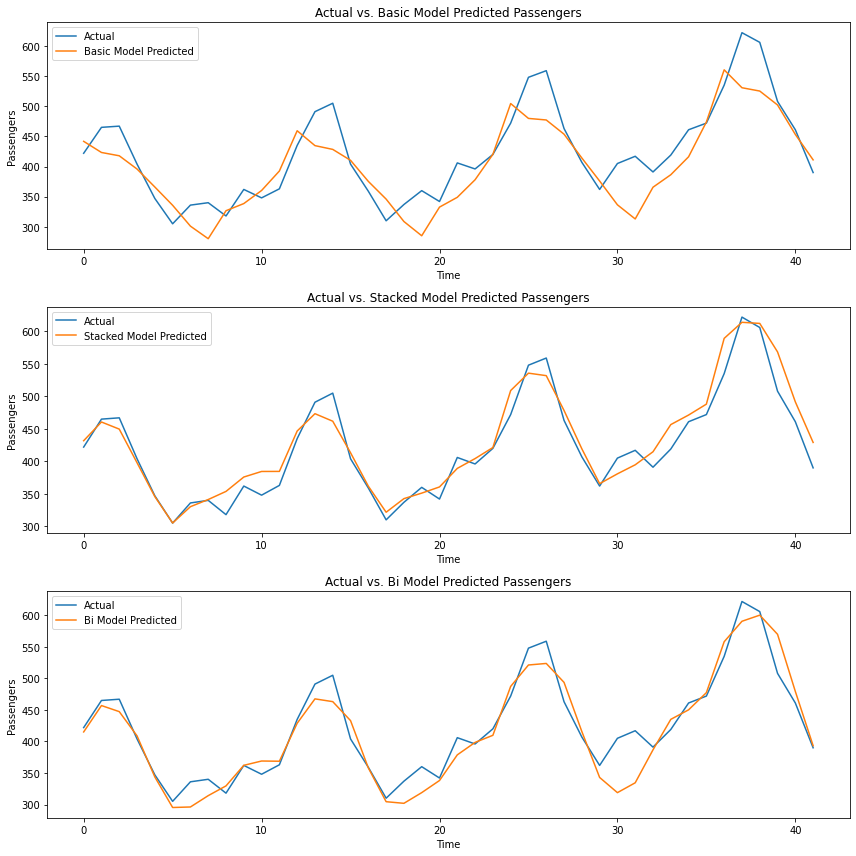

In [157]:
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

# Plot for Basic Model
axes[0].plot(original_testY, label='Actual')
axes[0].plot(basic_pred, label='Basic Model Predicted')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Passengers')
axes[0].legend()
axes[0].set_title('Actual vs. Basic Model Predicted Passengers')

# Plot for Stacked Model
axes[1].plot(original_testY, label='Actual')
axes[1].plot(stacked_pred, label='Stacked Model Predicted')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Passengers')
axes[1].legend()
axes[1].set_title('Actual vs. Stacked Model Predicted Passengers')

# Plot for Bi Model
axes[2].plot(original_testY, label='Actual')
axes[2].plot(bi_pred, label='Bi Model Predicted')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Passengers')
axes[2].legend()
axes[2].set_title('Actual vs. Bi Model Predicted Passengers')

plt.tight_layout() 
plt.show()

Note: Results can vary for different users and different runs of the analysis due to several factors, including random initialization of model weights, and differences in computing environments. Therefore, when applying these techniques to your own projects, it's advisable to perform multiple runs and cross-validation to ensure robustness and account for variability.